<h1> Logistic Regression using pySpark

In [2]:
#setting the bucket variable
BUCKET = 'my_first_project_0242'
os.environ['BUCKET'] = BUCKET

Check whether the spark-context/spark-session objects exists or not
Their default name is spark and sc

In [3]:
print spark

In [4]:
print sc

<SparkContext master=yarn appName=pyspark-shell>


yes! They do exist
If they don't exist we will have to create it using the following line of code:

==========


from pyspark.sql import SparkSession 
from pyspark import SparkContext 
sc = SparkContext('local','logistic')
spark = SparkSession.builder.appName("logistic regression using spark").getOrCreate()



==========

In [25]:
traindays = spark.read.option("header","true").csv('gs://{}/flights/trainday.csv'.format(BUCKET))
traindays.createOrReplaceTempView('traindays_view')


In [24]:
spark.sql('SELECT * from traindays_view LIMIT 5').show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-02|       False|
|2015-01-03|       False|
|2015-01-04|        True|
|2015-01-05|        True|
+----------+------------+



In [10]:
from pyspark.sql.types import StringType,StructField,FloatType,StructType
header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'


def get_structfield(colname):
  if colname in ['ARR_DELAY','DEP_DELAY','DISTANCE','TAXI_OUT']:
    return StructField(colname,FloatType(),True)
  else:
    return StructField(colname,StringType(),True)
  
  
schema = StructType([get_structfield(colname) for colname in header.split(',')])

In [86]:
#inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)
flights = spark.read.schema(schema).csv(inputs)

flights.createOrReplaceTempView('flights_view')
#flights.columns

traindays.columns

['FL_DATE', 'is_train_day']

Querying the relevant data

In [100]:
# query = """
# SELECT f.DEP_DELAY,f.TAXI_OUT,f.ARR_DELAY,f.DISTANCE from flights_view f 
# join traindays_view t  on f.FL_DATE == t.FL_DATE where t.is_train_day == 'True'
# """

query = """
SELECT
  f.DEP_DELAY,f.TAXI_OUT,f.ARR_DELAY,f.DISTANCE
FROM flights_view f
JOIN traindays_view t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""


# trainquery = """
# SELECT
#   f.DEP_DELAY,f.TAXI_OUT,f.ARR_DELAY,f.DISTANCE
# FROM flights_view f
# JOIN traindays_view t
# ON f.FL_DATE == t.FL_DATE
# WHERE
#   t.is_train_day == 'True'
# """

data = spark.sql(query)
print(data.head(2))

[Row(DEP_DELAY=51.0, TAXI_OUT=26.0, ARR_DELAY=46.0, DISTANCE=567.0), Row(DEP_DELAY=-1.0, TAXI_OUT=13.0, ARR_DELAY=-16.0, DISTANCE=67.0)]


In [101]:
data.describe().show()

+-------+-----------------+-----------------+-----------------+-----------------+
|summary|        DEP_DELAY|         TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+-----------------+-----------------+-----------------+-----------------+
|  count|           470518|           470288|           468986|           473916|
|   mean| 8.95174467289243|16.10602651991971|3.612269875859834|829.2826534660151|
| stddev|35.14741134234194| 8.74350523336888|37.10003871707921|617.3164121106863|
|    min|            -41.0|              1.0|            -81.0|             31.0|
|    max|           1878.0|            177.0|           1898.0|           4983.0|
+-------+-----------------+-----------------+-----------------+-----------------+



Note that the number of values of DISTANCE/DEP_DELAY/TAXI_OUT/ARR_DELAY are not the same
We need to remove the diverted or the cancelled flights

<h3>Logistic Regression

In [103]:
query = """
SELECT
  f.DEP_DELAY,f.TAXI_OUT,f.ARR_DELAY,f.DISTANCE
FROM flights_view f
JOIN traindays_view t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' and 
  f.ARR_DELAY is not null and
  f.DEP_DELAY is not null
"""
data = spark.sql(query)
data.describe().show()

+-------+------------------+-----------------+-----------------+-----------------+
|summary|         DEP_DELAY|         TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+-----------------+-----------------+-----------------+
|  count|            468986|           468986|           468986|           468986|
|   mean| 8.890148106766514|16.09936970399969|3.612269875859834|830.3768236152039|
| stddev|35.023425762235405|8.731830083231012|37.10003871707921|  617.77572595311|
|    min|             -41.0|              1.0|            -81.0|             31.0|
|    max|            1878.0|            177.0|           1898.0|           4983.0|
+-------+------------------+-----------------+-----------------+-----------------+



Now all the values are equal. Here we could do away with the flights that doesnot have DEP_DELAY/ARR_DELAY. In other cases, certain other scenarios must be taken care of 

Just to check that we have done right or not we will use an alternate query

In [104]:
query = """
SELECT
  f.DEP_DELAY,f.TAXI_OUT,f.ARR_DELAY,f.DISTANCE
FROM flights_view f
JOIN traindays_view t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' and 
  f.CANCELLED == '0.00' and
  f.DIVERTED == '0.00' 
"""
data = spark.sql(query)
data.describe().show()

+-------+------------------+-----------------+-----------------+-----------------+
|summary|         DEP_DELAY|         TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+-----------------+-----------------+-----------------+
|  count|            468986|           468986|           468986|           468986|
|   mean| 8.890148106766514|16.09936970399969|3.612269875859834|830.3768236152039|
| stddev|35.023425762235405|8.731830083231012|37.10003871707921|  617.77572595311|
|    min|             -41.0|              1.0|            -81.0|             31.0|
|    max|            1878.0|            177.0|           1898.0|           4983.0|
+-------+------------------+-----------------+-----------------+-----------------+



Both the values are coming out to be same....!!
So our assumption is correct


Creating a labeled point from the dataset

In [108]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

In [109]:
def to_example(fields):
  return LabeledPoint(float(fields['ARR_DELAY'] < 15),[fields['DEP_DELAY'],fields['DISTANCE'],fields['TAXI_OUT']])
  

Creating RDD from the current datasets

In [111]:
data_rdd = data.rdd.map(to_example)


Creating a logistic regression model and training the model with the given examples


In [113]:
#model = LogisticRegressionWithLBFGS.train(data_rdd,intercept=True)
print model.weights,model.intercept

[-0.17296318144717224,0.0003554348034534262,-0.1297964614258748] 5.44987500342


Now we have trained the model

Now we are ready for predicting the values

In [124]:
print model.predict([15.0,100.0,100.0])
print model.predict([2.0,594.0,3.0])

0
1


Here the implicit probability threshold is 0.5 

Removing the probability threshold of 0.5 

In [134]:
model.clearThreshold()
print model.predict([25.0,100.0,10.0])
print model.predict([2.0,594.0,3.0])

0.465896616276
0.992794560511


<h3>Predict with the model</h3>

saving the model

In [137]:
!gsutil -m rm -r gs://$BUCKET/flights/spark_ml_output/logistic_reg_model
MODEL_FILE = 'gs://'+BUCKET+'/flights/spark_ml_output/logistic_reg_model'
model.save(sc,MODEL_FILE)

CommandException: 1 files/objects could not be removed.


Erasing the model

In [138]:
model = 0

Retriving the model from remote cloud bucket

In [139]:
from pyspark.mllib.classification import LogisticRegressionModel
model = LogisticRegressionModel.load(sc,MODEL_FILE)


Setting the thresold to 0.7

In [ ]:
model.setThreshold(0.7)

Predicting once again 

In [140]:
model.predict([9.0,879.0,10.0])

1

<h3>Examining the model behaviour </h3>

First we try to plot the probability with respect to with respect to distance

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [143]:
dist = np.arange(0,600,10)


Lets keep the DEP_DELAY=10 and TAXI_OUT = 15 min as constant

In [147]:
model.clearThreshold()
prob = [model.predict([10,d,15]) for d in dist]


Plotting the graph using matplotlib

Text(0,0.5,u'probabilty')

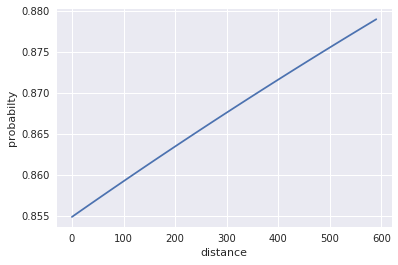

In [152]:
plt.plot(dist,prob)

plt.xlabel('distance')
plt.ylabel('probabilty')

Probabilty variation with respect to DEP_DELAY

Text(0,0.5,u'probability')

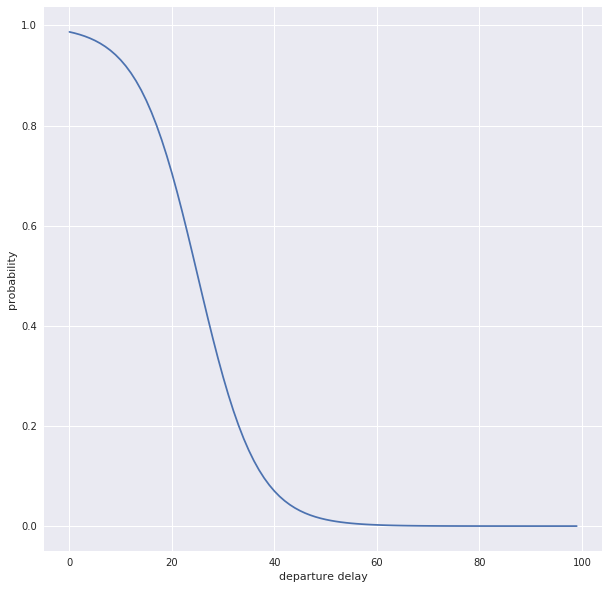

In [165]:
dep_delay = np.arange(0,100,1)
prob = [model.predict([dd,500.0,10.0]) for dd in dep_delay]


plt.figure(figsize=(10,10))
plt.plot(dep_delay,prob)
plt.xlabel('departure delay')
plt.ylabel('probability')